Nama: Agus Heryanto
NIM: 22.11.4661

In [28]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn missingno scikit-learn imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from google.colab import files
import io
import warnings
from scipy import stats
import re
import sys
from imblearn.pipeline import Pipeline
from datetime import datetime

warnings.filterwarnings('ignore')

# # Set style yang benar untuk visualisasi
# plt.style.use('default')  # atau 'classic'
# sns.set_theme()  # Menggunakan default seaborn theme

# # Set options pandas
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.width', 1000)

print("All libraries imported successfully!")

# Fungsi untuk mengecek instalasi
def check_installations():
    libraries = {
        'pandas': pd,
        'numpy': np,
        'matplotlib': plt,
        'seaborn': sns,
        'missingno': msno,
        'sklearn': SimpleImputer,
        'imblearn': SMOTE
    }

    print("Checking installations...")
    for lib_name, lib in libraries.items():
        if lib:
            print(f"✓ {lib_name} successfully imported")
        else:
            print(f"✗ {lib_name} import failed")

# Run check
check_installations()

All libraries imported successfully!
Checking installations...
✓ pandas successfully imported
✓ numpy successfully imported
✓ matplotlib successfully imported
✓ seaborn successfully imported
✓ missingno successfully imported
✓ sklearn successfully imported
✓ imblearn successfully imported


In [29]:
# Load dataset
# uploaded = files.upload()
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#         name=fn, length=len(uploaded[fn])))
# df = pd.read_csv(io.BytesIO(uploaded[fn]))

url = "https://raw.githubusercontent.com/agusheryanto182/job-recommendations/refs/heads/develop/scraper-service/linkedin_jobs_20250407_020136.csv"
df = pd.read_csv(url)

1. DATA DESCRIPTION

a. Dimensi Dataset:
Jumlah baris: 1182
Jumlah kolom: 15

b. Tipe Data Setiap Kolom:
job_id                int64
title                object
company              object
location_city        object
location_province    object
location_country     object
seniority_level      object
employment_level     object
job_function         object
industries           object
posted_date          object
description          object
keywords             object
link                 object
num_applicants       object
dtype: object

c. Statistik Deskriptif:
             job_id
count  1.182000e+03
mean   4.170715e+09
std    6.039651e+07
min    3.318539e+09
25%    4.175061e+09
50%    4.189546e+09
75%    4.195254e+09
max    4.202307e+09

d. Sample Data (5 baris pertama):
       job_id                          title  \
0  4199554439       Internship Web Developer   
1  4188450252            Front End Developer   
2  4178221580                  Web Developer   
3  4158977188               

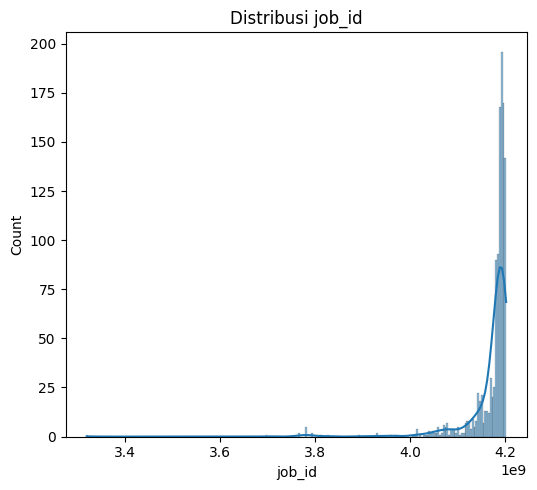


c. Box Plot untuk Deteksi Outlier


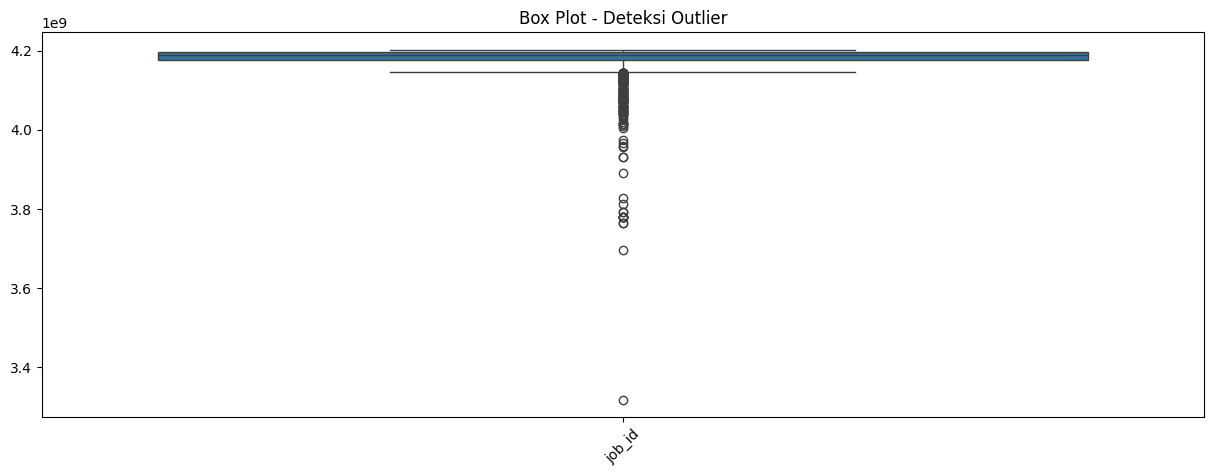


d. Analisis Missing Values:

Kolom dengan missing values:
                  Missing Values  Percentage Data Type
seniority_level              149       12.61    object
keywords                      10        0.85    object
employment_level               1        0.08    object
job_function                   1        0.08    object
industries                     1        0.08    object

Contoh nilai yang dianggap missing:

seniority_level:
6     nan
10    nan
30    nan
39    nan
45    nan

keywords:
32     nan
120    nan
123    nan
124    nan
133    nan

employment_level:
755    nan

job_function:
755    nan

industries:
755    nan

3. DATA QUALITY ASSESSMENT

a. Kelengkapan Data:
                   Total Rows  Missing Values  Completeness (%) Data Type
seniority_level          1182             149             87.39    object
keywords                 1182              10             99.15    object
job_function             1182               1             99.92    object
employment_lev

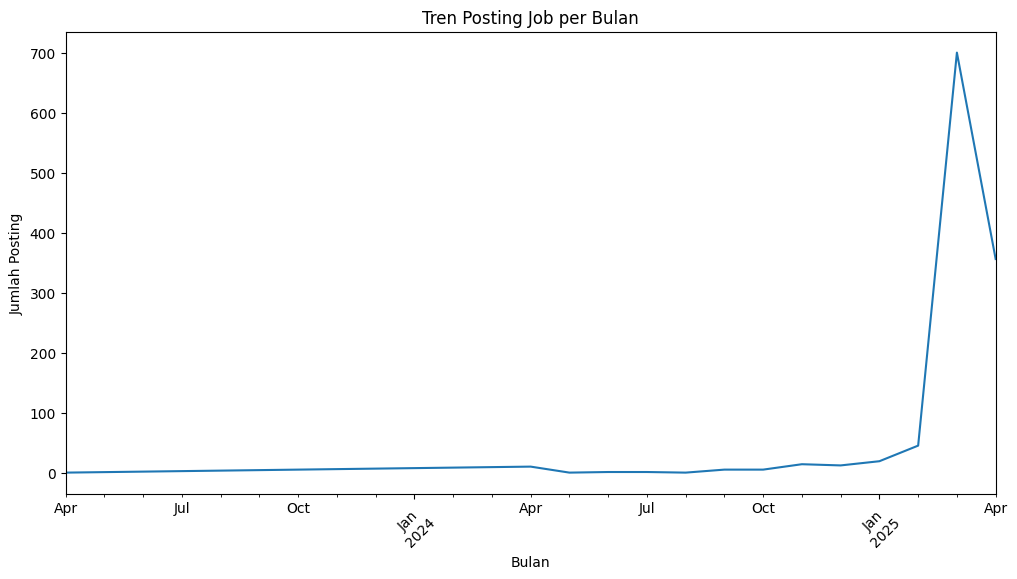


Top 10 Keywords:
development: 783
support: 759
service: 691
lead: 660
design: 614
communication: 602
product: 594
systems: 476
intern: 461
git: 436


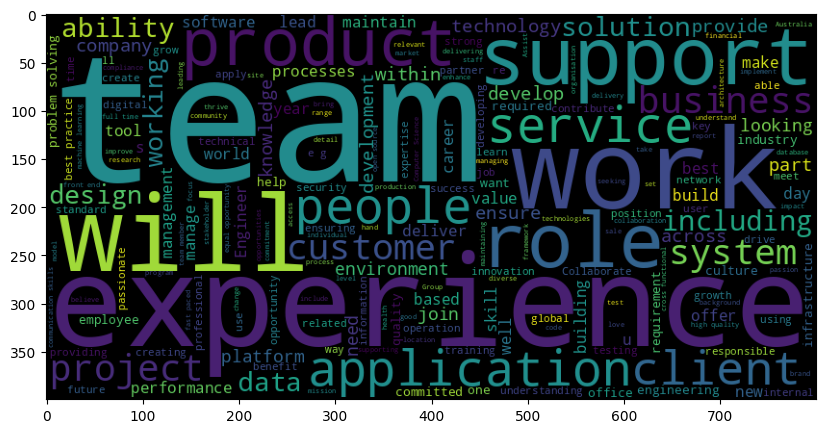

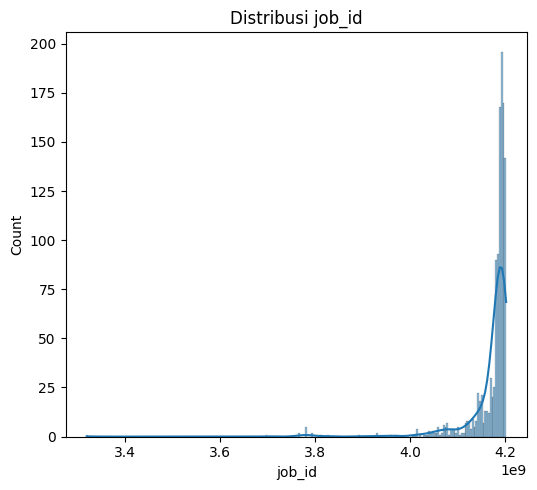

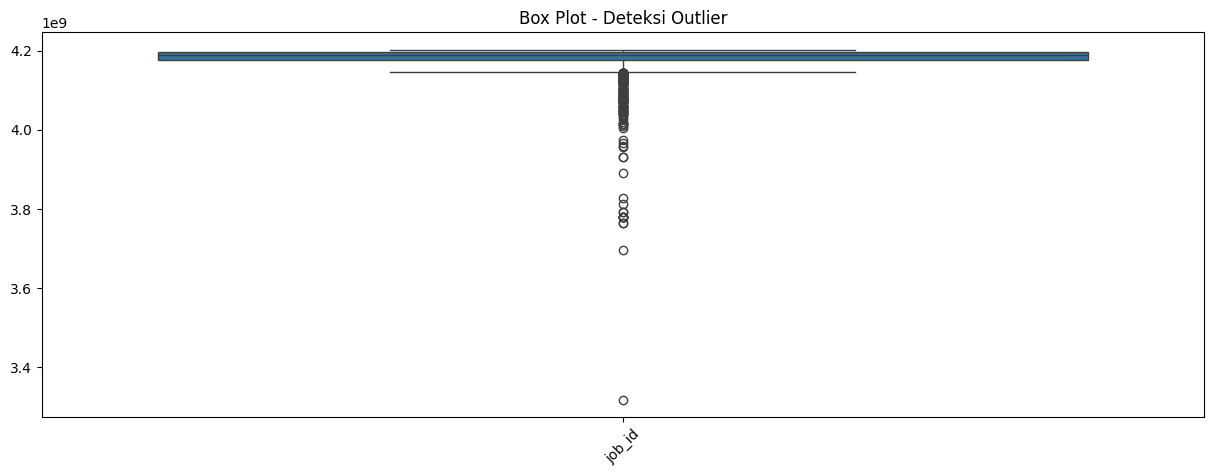

Laporan telah disimpan ke data_analysis_report.txt


In [30]:
def clean_text(text):
    # Using regular expression to remove newline characters
    # and ensure text is a string (handles NaN as well)
    return re.sub(r'\n', ' ', str(text))

def comprehensive_data_analysis(df):
    """
    Fungsi untuk melakukan analisis komprehensif dataset
    """

    # Cleaning the categorical columns that might be used for labels
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(clean_text)

    # 1. DATA DESCRIPTION
    print("="*50)
    print("1. DATA DESCRIPTION")
    print("="*50)

    # a. Jumlah observasi dan fitur
    print("\na. Dimensi Dataset:")
    print(f"Jumlah baris: {df.shape[0]}")
    print(f"Jumlah kolom: {df.shape[1]}")

    # b. Tipe data setiap kolom
    print("\nb. Tipe Data Setiap Kolom:")
    print(df.dtypes)

    # c. Statistik deskriptif
    print("\nc. Statistik Deskriptif:")
    print(df.describe())

    # d. Sampel data
    print("\nd. Sample Data (5 baris pertama):")
    print(df.head())

    # 2. DATA EXPLORATION
    print("\n" + "="*50)
    print("2. DATA EXPLORATION")
    print("="*50)

    # a. Visualisasi distribusi untuk kolom numerik
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 0:
        print("\na. Visualisasi Distribusi Kolom Numerik")
        plt.figure(figsize=(15, 5*((len(numeric_cols)-1)//3 + 1)))
        for i, col in enumerate(numeric_cols, 1):
            plt.subplot((len(numeric_cols)-1)//3 + 1, 3, i)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribusi {col}')
        plt.tight_layout()
        plt.show()

    # b. Korelasi antar variabel numerik
    if len(numeric_cols) > 1:
        print("\nb. Heatmap Korelasi")
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.show()

    # c. Box Plot untuk deteksi outlier
    if len(numeric_cols) > 0:
        print("\nc. Box Plot untuk Deteksi Outlier")
        plt.figure(figsize=(15, 5))
        sns.boxplot(data=df[numeric_cols])
        plt.xticks(rotation=45)
        plt.title('Box Plot - Deteksi Outlier')
        plt.show()

    # d. Analisis Missing Values
    print("\nd. Analisis Missing Values:")

    def check_missing(series):
        """
        Fungsi untuk mengecek berbagai jenis missing values:
        - NaN values
        - Empty strings
        - 'nan' strings (case insensitive)
        - Whitespace-only strings
        """
        return (
            series.isna() |  # NaN values
            (series.astype(str).str.strip() == '') |  # Empty atau whitespace strings
            (series.astype(str).str.lower() == 'nan')  # 'nan' strings
        )

    # Hitung missing values untuk setiap kolom
    missing_counts = pd.DataFrame({
        'Missing Values': [check_missing(df[col]).sum() for col in df.columns],
        'Percentage': [check_missing(df[col]).mean() * 100 for col in df.columns]
    }, index=df.columns)

    # Tambahkan kolom untuk tipe data
    missing_counts['Data Type'] = df.dtypes

    # Format persentase dengan 2 desimal
    missing_counts['Percentage'] = missing_counts['Percentage'].round(2)

    # Tampilkan hanya kolom yang memiliki missing values
    missing_report = missing_counts[missing_counts['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

    if len(missing_report) > 0:
        print("\nKolom dengan missing values:")
        print(missing_report)

        # Tampilkan contoh nilai yang dianggap missing untuk setiap kolom
        print("\nContoh nilai yang dianggap missing:")
        for col in missing_report.index:
            missing_mask = check_missing(df[col])
            if missing_mask.any():
                print(f"\n{col}:")
                print(df.loc[missing_mask, col].head().to_string())
    else:
        print("\nTidak ada missing values dalam dataset")

    return None


# Fungsi untuk menghasilkan laporan dalam format yang bisa disimpan
def generate_analysis_report(df, output_file="data_analysis_report.txt"):
    """
    Menghasilkan laporan analisis dan menyimpannya ke file
    """

    # Redirect output ke string buffer
    old_stdout = sys.stdout
    result = io.StringIO()
    sys.stdout = result

    # Jalankan analisis
    comprehensive_data_analysis(df)

    # Restore stdout dan dapatkan string output
    sys.stdout = old_stdout

    # Simpan ke file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(result.getvalue())

    print(f"Laporan telah disimpan ke {output_file}")

# Analisis Kategorikal yang Lebih Detail
def analyze_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"\nAnalisis kolom {col}:")
        print(df[col].value_counts().head())
        print(f"Total kategori unik: {df[col].nunique()}")

        # # Visualisasi
        # plt.figure(figsize=(10, 5))
        # df[col].value_counts().plot(kind='bar')
        # plt.title(f'Distribusi {col}')

        # # Replace newline characters in x-axis tick labels
        # plt.xticks(rotation=45, ha='right')  # Adjust horizontal alignment
        # labels = [label.get_text().replace('\n', ' ') for label in plt.gca().get_xticklabels()]
        # plt.gca().set_xticklabels(labels)

        # plt.show()

# Analisis Temporal (untuk kolom posted_date)
def analyze_temporal_data(df):
    df['posted_date'] = pd.to_datetime(df['posted_date'])

    print("\nAnalisis Temporal:")
    print("Range tanggal:", df['posted_date'].min(), "sampai", df['posted_date'].max())

    # Tren posting per bulan
    monthly_posts = df['posted_date'].dt.to_period('M').value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    monthly_posts.plot(kind='line')
    plt.title('Tren Posting Job per Bulan')
    plt.xlabel('Bulan')
    plt.ylabel('Jumlah Posting')
    plt.xticks(rotation=45)
    plt.show()

def analyze_data_quality(df):
        """
        Fungsi untuk melakukan analisis kualitas data secara menyeluruh
        """
        print("\n" + "="*50)
        print("3. DATA QUALITY ASSESSMENT")
        print("="*50)

        # a. Kelengkapan Data
        print("\na. Kelengkapan Data:")

        def check_missing(series):
            """Cek semua jenis missing values"""
            return (
                series.isna() |
                (series.astype(str).str.strip() == '') |
                (series.astype(str).str.lower() == 'nan')
            )

        completeness_stats = pd.DataFrame({
            'Total Rows': len(df),
            'Missing Values': [check_missing(df[col]).sum() for col in df.columns],
            'Completeness (%)': [(1 - check_missing(df[col]).mean()) * 100 for col in df.columns],
            'Data Type': df.dtypes
        }, index=df.columns)

        completeness_stats['Completeness (%)'] = completeness_stats['Completeness (%)'].round(2)
        print(completeness_stats.sort_values('Completeness (%)', ascending=True))

        # b. Konsistensi Data (Duplikasi)
        print("\nb. Analisis Duplikasi:")
        # Cek duplikasi berdasarkan semua kolom
        all_duplicates = df.duplicated().sum()
        # Cek duplikasi berdasarkan job_id
        id_duplicates = df.duplicated(subset=['job_id']).sum()

        print(f"Jumlah baris duplikat (semua kolom): {all_duplicates}")
        print(f"Jumlah job_id duplikat: {id_duplicates}")

        if id_duplicates > 0:
            print("\nContoh job_id yang duplikat:")
            duplicate_ids = df[df.duplicated(subset=['job_id'], keep=False)]['job_id'].unique()
            print(df[df['job_id'].isin(duplicate_ids[:3])].sort_values('job_id'))

        # c. Akurasi Data
        print("\nc. Pemeriksaan Akurasi Data:")

        # Analisis kolom numerik
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        if len(numeric_cols) > 0:
            numeric_stats = df[numeric_cols].agg(['count', 'min', 'max', 'mean', 'std']).round(2)
            print("\nStatistik kolom numerik:")
            print(numeric_stats)

        # Analisis kolom kategorikal
        categorical_cols = df.select_dtypes(include=['object']).columns
        print("\nAnalisis kolom kategorikal:")
        for col in categorical_cols:
            value_counts = df[col].value_counts()
            print(f"\n{col}:")
            print(f"- Top 5 nilai terbanyak:")
            print(value_counts.head())
            print(f"- Bottom 5 nilai:")
            print(value_counts.tail())

        # d. Analisis Keunikan
        print("\nd. Analisis Keunikan:")
        uniqueness_stats = pd.DataFrame({
            'Unique Values': [df[col].nunique() for col in df.columns],
            'Uniqueness (%)': [(df[col].nunique() / len(df)) * 100 for col in df.columns],
            'Sample Values': [', '.join(df[col].astype(str).unique()[:3]) for col in df.columns]
        }, index=df.columns)

        uniqueness_stats['Uniqueness (%)'] = uniqueness_stats['Uniqueness (%)'].round(2)
        print(uniqueness_stats.sort_values('Uniqueness (%)', ascending=False))

        # e. Validasi Format
        print("\ne. Validasi Format:")

        # Cek format tanggal
        if 'posted_date' in df.columns:
            invalid_dates = pd.to_datetime(df['posted_date'], errors='coerce').isna().sum()
            print(f"\nposted_date: {invalid_dates} nilai dengan format tanggal tidak valid")

        # Cek format num_applicants
        if 'num_applicants' in df.columns:
            invalid_numbers = df['num_applicants'].apply(lambda x: not str(x).replace('-', '').isdigit() if pd.notna(x) else False).sum()
            print(f"num_applicants: {invalid_numbers} nilai dengan format angka tidak valid")

        # f. Rekomendasi
        print("\nf. Rekomendasi Perbaikan Data:")

        # Berikan rekomendasi berdasarkan temuan
        if completeness_stats['Missing Values'].any():
            print("\n1. Missing Values:")
            for col in completeness_stats[completeness_stats['Missing Values'] > 0].index:
                print(f"   - {col}: {completeness_stats.loc[col, 'Missing Values']} nilai kosong perlu diimpute")

        if all_duplicates > 0:
            print("\n2. Duplikasi:")
            print(f"   - Pertimbangkan untuk menghapus atau menggabungkan {all_duplicates} baris duplikat")

        if 'num_applicants' in df.columns and invalid_numbers > 0:
            print("\n3. Format Data:")
            print(f"   - Perbaiki {invalid_numbers} nilai tidak valid pada kolom num_applicants")

# Analisis Text untuk Description dan Keywords
from collections import Counter
import re

def analyze_text_data(df):
    # Analisis keywords
    all_keywords = []
    for keywords in df['keywords'].str.split('|'):
        if isinstance(keywords, list):
            all_keywords.extend(keywords)

    keyword_freq = Counter(all_keywords)

    print("\nTop 10 Keywords:")
    for keyword, count in keyword_freq.most_common(10):
        print(f"{keyword}: {count}")

    # Word cloud untuk description
    from wordcloud import WordCloud

    text = ' '.join(df['description'])
    wordcloud = WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis


# 2. Jalankan analisis
comprehensive_data_analysis(df)

analyze_data_quality(df)

analyze_categorical_columns(df)

analyze_temporal_data(df)

analyze_text_data(df)

# 3. Generate dan simpan laporan
generate_analysis_report(df)

In [31]:
# Function to convert applicant numbers to numeric values
def convert_applicants_to_numeric(value):
    """
    Mengkonversi jumlah pelamar ke bilangan bulat
    Returns: int (bilangan bulat) atau np.nan
    """
    if pd.isna(value):
        return 0  # Ubah np.nan menjadi 0

    value = str(value).lower().strip()

    try:
        if 'over 200' in value:
            return 200
        elif 'be among the first' in value:
            try:
                return int(value.split()[4])
            except:
                return 0
        else:
            # Ekstrak angka dari string
            numbers = ''.join(filter(str.isdigit, value))
            return int(numbers) if numbers else 0
    except:
        return 0  # Return 0 jika ada error

# Function to safely handle keywords
def clean_keywords(value):
    if pd.isna(value):
        return ''
    if isinstance(value, list):
        return '|'.join(map(str, value))
    if isinstance(value, str):
        cleaned = value.replace('[', '').replace(']', '').replace("'", "")
        return cleaned
    return str(value)

# Missing Value Analysis
def analyze_missing_values(df):
    """
    Analisis missing value dengan penanganan khusus untuk 'nan' string
    """
    total_rows = len(df)

    # Fungsi untuk mengecek missing value
    def check_missing(series):
        # Cek NaN/None
        null_mask = series.isnull()
        # Cek string kosong
        empty_mask = (series == '') | (series == ' ')
        # Cek string 'nan'
        nan_string_mask = (series.astype(str).str.lower() == 'nan')
        # Gabungkan semua kondisi
        return null_mask | empty_mask | nan_string_mask

    # Hitung missing values
    missing_values = df.apply(check_missing).sum()
    missing_percentage = (missing_values / total_rows) * 100

    # Buat DataFrame hasil
    missing_info = pd.DataFrame({
        'Missing Values': missing_values,
        'Missing Percentage': missing_percentage
    })

    # Print detail untuk setiap kolom
    print("\nDetail missing values per kolom:")
    for col in df.columns:
        empty_count = (df[col] == '').sum()
        null_count = df[col].isnull().sum()
        nan_string_count = (df[col].astype(str).str.lower() == 'nan').sum()
        total_missing = empty_count + null_count + nan_string_count

        if total_missing > 0:
            print(f"\n{col}:")
            if empty_count > 0:
                print(f"  - Empty strings: {empty_count}")
            if null_count > 0:
                print(f"  - Null values: {null_count}")
            if nan_string_count > 0:
                print(f"  - 'nan' strings: {nan_string_count}")
            print(f"  - Total missing: {total_missing}")
            print(f"  - Percentage: {(total_missing / total_rows) * 100:.2f}%")
            # Tampilkan beberapa contoh nilai
            print(f"  - Sample values: {df[col].head().tolist()}")

    return missing_info.sort_values('Missing Percentage', ascending=False)

# Enhanced Missing Value Imputation with multiple strategies
def impute_missing_values(df, strategy='simple'):
    """
    Enhanced imputation untuk semua jenis missing values
    """
    df_imputed = df.copy()

    # 1. Handle keywords - menggunakan title dari row yang sama
    def get_keywords_from_title(title):
        """Helper function untuk mengekstrak keywords dari title"""
        if pd.isna(title) or str(title).strip() == '' or str(title).lower() == 'nan':
            return ''
        # Bersihkan dan split title menjadi keywords
        words = str(title).lower().split()
        # Hilangkan kata-kata umum yang tidak relevan
        stop_words = {'and', 'or', 'the', 'in', 'at', 'of', 'for', 'to', 'with'}
        keywords = [word for word in words if word not in stop_words]
        return '|'.join(keywords)

    # Untuk setiap row, jika keywords kosong, gunakan title dari row yang sama
    df_imputed['keywords'] = df_imputed.apply(
        lambda row: get_keywords_from_title(row['title'])  # menggunakan title dari row yang sama
        if pd.isna(row['keywords']) or str(row['keywords']).strip() == '' or str(row['keywords']).lower() == 'nan'
        else clean_keywords(row['keywords']),
        axis=1
    )

    # 2. Convert num_applicants
    df_imputed['num_applicants'] = df_imputed['num_applicants'].apply(convert_applicants_to_numeric)

    # 3. Imputation berdasarkan strategy
    if strategy == 'simple':
        # Categorical columns
        categorical_columns = [
            'title', 'company', 'location_city', 'location_province',
            'location_country', 'seniority_level', 'employment_level',
            'job_function', 'industries'
        ]

        # Mode imputation untuk categorical
        for col in categorical_columns:
            # Handle semua jenis missing values
            mask = (df_imputed[col].isna()) | \
                   (df_imputed[col] == '') | \
                   (df_imputed[col].astype(str).str.lower() == 'nan')

            mode_value = df_imputed[~mask][col].mode()[0]
            df_imputed.loc[mask, col] = mode_value

        # Numeric columns
        numeric_columns = ['job_id', 'num_applicants']
        for col in numeric_columns:
            median_value = df_imputed[col].median()
            df_imputed[col] = df_imputed[col].fillna(median_value)

    elif strategy == 'knn':
        # Numeric features untuk KNN
        numeric_columns = ['job_id', 'num_applicants']

        # Pastikan data numerik valid untuk KNN
        for col in numeric_columns:
            df_imputed[col] = pd.to_numeric(df_imputed[col], errors='coerce')

        # KNN imputation
        knn_imputer = KNNImputer(n_neighbors=5)
        df_imputed[numeric_columns] = knn_imputer.fit_transform(df_imputed[numeric_columns])

        # Categorical columns
        categorical_columns = [
            'title', 'company', 'location_city', 'location_province',
            'location_country', 'seniority_level', 'employment_level',
            'job_function', 'industries'
        ]

        # Mode imputation untuk categorical
        for col in categorical_columns:
            # Handle semua jenis missing values
            mask = (df_imputed[col].isna()) | \
                   (df_imputed[col] == '') | \
                   (df_imputed[col].astype(str).str.lower() == 'nan')

            mode_value = df_imputed[~mask][col].mode()[0]
            df_imputed.loc[mask, col] = mode_value

    # 4. Handle date column
    df_imputed['posted_date'] = pd.to_datetime(df_imputed['posted_date'], errors='coerce')
    mean_date = df_imputed['posted_date'].mean()
    df_imputed['posted_date'] = df_imputed['posted_date'].fillna(mean_date)

    # 5. Handle text columns
    df_imputed['description'] = df_imputed['description'].apply(
        lambda x: '' if pd.isna(x) or str(x).strip() == '' or str(x).lower() == 'nan'
        else str(x)
    )

    # 6. Final check untuk keywords
    empty_keywords = df_imputed['keywords'].apply(
        lambda x: pd.isna(x) or str(x).strip() == '' or str(x).lower() == 'nan'
    )
    if empty_keywords.any():
        df_imputed.loc[empty_keywords, 'keywords'] = default_keywords

    # 7. Final verification untuk semua kolom
    for col in df_imputed.columns:
        # Check berbagai jenis missing values
        mask = (df_imputed[col].isna()) | \
               (df_imputed[col].astype(str) == '') | \
               (df_imputed[col].astype(str).str.lower() == 'nan')

        if mask.any():
            print(f"\nWarning: Masih ada missing values di kolom {col}")
            print(f"Jumlah: {mask.sum()}")
            print("Sample values:")
            print(df_imputed.loc[mask, col].head())

            # Auto-fix untuk missing values yang tersisa
            if col in categorical_columns:
                df_imputed.loc[mask, col] = df_imputed[~mask][col].mode()[0]
            elif col in numeric_columns:
                df_imputed.loc[mask, col] = df_imputed[~mask][col].median()
            elif col == 'keywords':
                df_imputed.loc[mask, col] = default_keywords
            elif col == 'description':
                df_imputed.loc[mask, col] = ''
            elif col == 'posted_date':
                df_imputed.loc[mask, col] = mean_date

    return df_imputed

# Class Imbalance Handling
def handle_class_imbalance(df, target_column='seniority_level', method='smote'):
    """
    Handle class imbalance for multi-class target dengan menjaga semua kolom
    """
    # Simpan semua kolom original
    original_columns = df.columns.tolist()

    # Prepare the data
    numeric_features = ['num_applicants']
    categorical_features = ['employment_level', 'job_function']

    # Buat copy dataframe untuk processing
    df_process = df.copy()

    # Encode categorical features
    le_dict = {}
    X = df_process[numeric_features].copy()

    for cat_col in categorical_features:
        le = LabelEncoder()
        X[cat_col] = le.fit_transform(df_process[cat_col].astype(str))
        le_dict[cat_col] = le

    # Encode target
    le_target = LabelEncoder()
    y = le_target.fit_transform(df_process[target_column].astype(str))

    # Calculate class distribution
    class_counts = Counter(y)
    max_class_count = max(class_counts.values())

    # Define sampling strategy
    sampling_strategy = {
        class_label: max_class_count
        for class_label in class_counts.keys()
        if class_counts[class_label] < max_class_count
    }

    # Apply SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)

    # Create balanced dataframe dengan semua kolom
    df_balanced = pd.DataFrame(X_balanced, columns=numeric_features)

    # Decode categorical features
    for cat_col in categorical_features:
        df_balanced[cat_col] = le_dict[cat_col].inverse_transform(X_balanced[cat_col].astype(int))

    # Tambahkan target column yang sudah dibalancing
    df_balanced[target_column] = le_target.inverse_transform(y_balanced)

    # Copy kolom lain dari dataframe original
    other_columns = [col for col in original_columns if col not in
                    (numeric_features + categorical_features + [target_column])]

    # Ulangi nilai dari kolom lain sesuai dengan jumlah baris yang dibalancing
    for col in other_columns:
        # Ambil nilai unik dari kolom original
        unique_values = df[col].dropna().unique()
        # Generate nilai untuk baris baru
        if len(unique_values) > 0:
            df_balanced[col] = np.random.choice(unique_values, size=len(df_balanced))
        else:
            df_balanced[col] = None

    # Pastikan urutan kolom sama dengan dataframe original
    df_balanced = df_balanced[original_columns]

    return df_balanced

# Analysis of class balance
def analyze_class_distribution(df, column):
    print(f"\nClass distribution for {column}:")
    distribution = df[column].value_counts(normalize=True)
    print(distribution)
    return distribution

# Preprocessing untuk membersihkan data
def clean_data(df):
    """
    Membersihkan data dengan mengganti 'nan' string menjadi numpy.nan
    """
    df_clean = df.copy()

    # Ganti string 'nan' dengan numpy.nan
    for column in df_clean.columns:
        mask = df_clean[column].astype(str).str.lower() == 'nan'
        df_clean.loc[mask, column] = np.nan

    return df_clean


def evaluate_data_quality(df_original, df_processed):
    """
    Mengevaluasi kualitas data sebelum dan sesudah preprocessing
    """
    print("\n" + "="*50)
    print("1. METRIK EVALUASI")
    print("="*50)

    metrics = {
        'Total Rows': [len(df_original), len(df_processed)],
        'Missing Values (Total)': [
            df_original.isna().sum().sum(),
            df_processed.isna().sum().sum()
        ],
        'Duplicate Rows': [
            df_original.duplicated().sum(),
            df_processed.duplicated().sum()
        ],
        'Unique Values per Column': {
            col: [
                df_original[col].nunique(),
                df_processed[col].nunique()
            ] for col in df_original.columns
        }
    }

    # Tampilkan metrik dasar
    print("\na. Basic Metrics:")
    for metric in ['Total Rows', 'Missing Values (Total)', 'Duplicate Rows']:
        print(f"\n{metric}:")
        print(f"- Original: {metrics[metric][0]}")
        print(f"- Processed: {metrics[metric][1]}")
        if metric != 'Total Rows':
            print(f"- Improvement: {((metrics[metric][0] - metrics[metric][1])/metrics[metric][0]*100):.2f}%")

    # Analisis keunikan nilai
    print("\nb. Unique Values Analysis:")
    for col in df_original.columns:
        orig_unique = metrics['Unique Values per Column'][col][0]
        proc_unique = metrics['Unique Values per Column'][col][1]
        print(f"\n{col}:")
        print(f"- Original: {orig_unique} unique values")
        print(f"- Processed: {proc_unique} unique values")

    # Analisis distribusi kelas (untuk seniority_level)
    print("\nc. Class Distribution Analysis:")
    orig_dist = df_original['seniority_level'].value_counts(normalize=True)
    proc_dist = df_processed['seniority_level'].value_counts(normalize=True)

    print("\nSeniority Level Distribution:")
    comparison = pd.DataFrame({
        'Original (%)': (orig_dist * 100).round(2),
        'Processed (%)': (proc_dist * 100).round(2)
    })
    print(comparison)

    return metrics

def compare_results(df_original, df_processed):
    """
    Membandingkan hasil sebelum dan sesudah preprocessing
    """
    print("\n" + "="*50)
    print("2. PERBANDINGAN HASIL")
    print("="*50)

    # a. Statistical Comparison
    print("\na. Perbandingan Statistik:")
    # Fokus hanya pada kolom yang relevan untuk analisis
    relevant_numeric_cols = ['num_applicants']  # Hanya kolom yang bermakna untuk dianalisis

    for col in relevant_numeric_cols:
        print(f"\n{col} Statistics:")
        orig_stats = df_original[col].describe()
        proc_stats = df_processed[col].describe()

        stats_comparison = pd.DataFrame({
            'Original': orig_stats,
            'Processed': proc_stats,
            'Difference (%)': ((proc_stats - orig_stats)/orig_stats * 100).round(2)
        })
        print(stats_comparison)

    # b. Categorical Distribution Comparison
    print("\nb. Perbandingan Distribusi Kategorikal:")
    categorical_cols = [
        'seniority_level',
        'employment_level',
        'job_function',
        'industries'
    ]

    for col in categorical_cols:
        print(f"\n{col} Distribution:")
        orig_dist = df_original[col].value_counts(normalize=True) * 100
        proc_dist = df_processed[col].value_counts(normalize=True) * 100

        dist_comparison = pd.DataFrame({
            'Original (%)': orig_dist,
            'Processed (%)': proc_dist,
            'Difference (%)': (proc_dist - orig_dist).round(2)
        })
        print(dist_comparison.round(2))

    # c. Location Analysis
    print("\nc. Analisis Lokasi:")
    location_cols = ['location_city', 'location_province', 'location_country']

    for col in location_cols:
        print(f"\nTop 10 {col}:")
        orig_loc = df_original[col].value_counts().head(10)
        proc_loc = df_processed[col].value_counts().head(10)

        loc_comparison = pd.DataFrame({
            'Original Count': orig_loc,
            'Processed Count': proc_loc
        })
        print(loc_comparison)

    # d. Keywords Analysis
    print("\nd. Analisis Keywords:")

    def get_top_keywords(series, n=10):
        all_keywords = []
        for keywords in series.dropna():
            if isinstance(keywords, str):
                all_keywords.extend(keywords.split('|'))
        return pd.Series(all_keywords).value_counts().head(n)

    print("\nTop 10 Keywords Comparison:")
    orig_keywords = get_top_keywords(df_original['keywords'])
    proc_keywords = get_top_keywords(df_processed['keywords'])

    keywords_comparison = pd.DataFrame({
        'Original Count': orig_keywords,
        'Processed Count': proc_keywords
    })
    print(keywords_comparison)

    # e. Quality Metrics
    print("\ne. Metrik Kualitas:")

    def calculate_quality_metrics(df):
        return {
            'Completeness': (1 - df.isna().sum().mean()) * 100,
            'Class Balance (Seniority)': (1 - df['seniority_level'].value_counts(normalize=True).std()) * 100,
            'Unique Companies': df['company'].nunique(),
            'Avg Keywords per Job': df['keywords'].str.count('\|').mean() + 1
        }

    orig_metrics = calculate_quality_metrics(df_original)
    proc_metrics = calculate_quality_metrics(df_processed)

    metrics_comparison = pd.DataFrame({
        'Original': orig_metrics,
        'Processed': proc_metrics,
        'Improvement (%)': {k: proc_metrics[k] - orig_metrics[k] for k in orig_metrics}
    })
    print("\nQuality Metrics Comparison:")
    print(metrics_comparison.round(2))

    return {
        'numeric_stats': stats_comparison,
        'categorical_dist': dist_comparison,
        'quality_metrics': metrics_comparison
    }

def convert_numpy_to_python(obj):
    """
    Mengkonversi numpy types ke Python native types untuk JSON serialization
    """
    if isinstance(obj, dict):
        return {key: convert_numpy_to_python(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_python(item) for item in obj]
    elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64)):
        return int(obj)
    # Check for np.float64 instead of np.float_
    elif isinstance(obj, (np.float16, np.float32, np.float64)): # Changed np.float_ to np.float64
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, pd.Series):
        return obj.to_dict()
    elif isinstance(obj, pd.DataFrame):
        return obj.to_dict(orient='records')
    return obj

def main():
    """
    Main execution flow untuk data processing dan analysis
    """
    print("="*50)
    print("LINKEDIN JOB DATA ANALYSIS")
    print("="*50)

    # 1. Data Loading dan Initial Analysis
    print("\n1. Loading dan Analyzing Data...")

    # Tampilkan info dataset
    print("\nDataset Info:")
    print(f"Total Rows: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    print("\nColumns:", df.columns.tolist())

    # 2. Missing Value Analysis
    print("\n2. Missing Value Analysis")
    print("-"*30)

    # Original data analysis
    print("\na. Data Original:")
    original_analysis = analyze_missing_values(df)

    # Clean data
    print("\nb. Cleaning Data...")
    df_clean = clean_data(df)
    clean_analysis = analyze_missing_values(df_clean)

    # 3. Class Distribution Analysis
    print("\n3. Class Distribution Analysis")
    print("-"*30)

    print("\na. Initial Distribution:")
    initial_distribution = analyze_class_distribution(df_clean, 'seniority_level')

    # 4. Data Preprocessing
    print("\n4. Data Preprocessing")
    print("-"*30)

    # Apply imputation
    print("\na. Applying Missing Value Imputation...")
    df_imputed = impute_missing_values(df_clean, strategy='knn')

    # Verify imputation
    print("\nb. Verifying Imputation Results:")
    imputed_analysis = analyze_missing_values(df_imputed)

    # Handle class imbalance
    print("\nc. Handling Class Imbalance...")
    df_balanced = handle_class_imbalance(df_imputed, method='smote')

    print("\nd. Final Class Distribution:")
    final_distribution = analyze_class_distribution(df_balanced, 'seniority_level')

    # 5. Quality Evaluation
    print("\n5. Quality Evaluation")
    print("-"*30)

    # Evaluate data quality
    print("\na. Evaluating Data Quality...")
    quality_metrics = evaluate_data_quality(df, df_balanced)

    # Compare results
    print("\nb. Comparing Results...")
    comparison_results = compare_results(df, df_balanced)

    # 6. Save Results
    print("\n6. Saving Results")
    print("-"*30)

    # Save processed dataset
    output_file = 'processed_linkedin_jobs.csv'
    df_balanced.to_csv(output_file, index=False)
    print(f"\na. Processed dataset saved to: {output_file}")

    # automatic download csv file
    files.download(output_file)

    # Save evaluation results
    results_summary = {
        'quality_metrics': quality_metrics,
        'comparison_results': comparison_results,
        'processing_summary': {
            'original_shape': df.shape,
            'cleaned_shape': df_clean.shape,
            'balanced_shape': df_balanced.shape,
            'missing_values_improvement': {
                'original': original_analysis['Missing Values'].sum(),
                'final': imputed_analysis['Missing Values'].sum()
            },
            'class_distribution': {
                'initial': initial_distribution.to_dict(),
                'final': final_distribution.to_dict()
            }
        }
    }

    # Convert numpy types to Python native types
    results_summary = convert_numpy_to_python(results_summary)

    import json
    # Save evaluation results
    evaluation_file = 'evaluation_results.json'
    with open(evaluation_file, 'w') as f:
        json.dump(results_summary, f, indent=4)
    print(f"b. Evaluation results saved to: {evaluation_file}")

    # 7. Final Summary
    print("\n7. Processing Summary")
    print("-"*30)
    print(f"\nOriginal dataset: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"Final dataset: {df_balanced.shape[0]} rows, {df_balanced.shape[1]} columns")
    print(f"Missing values reduced from {original_analysis['Missing Values'].sum()} to {imputed_analysis['Missing Values'].sum()}")
    print("\nProcessing completed successfully!")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"\nError during execution: {str(e)}")
        raise

LINKEDIN JOB DATA ANALYSIS

1. Loading dan Analyzing Data...

Dataset Info:
Total Rows: 1182
Total Columns: 15

Columns: ['job_id', 'title', 'company', 'location_city', 'location_province', 'location_country', 'seniority_level', 'employment_level', 'job_function', 'industries', 'posted_date', 'description', 'keywords', 'link', 'num_applicants']

2. Missing Value Analysis
------------------------------

a. Data Original:

Detail missing values per kolom:

seniority_level:
  - 'nan' strings: 149
  - Total missing: 149
  - Percentage: 12.61%
  - Sample values: ['internship', 'associate', 'associate', 'entry level', 'entry level']

employment_level:
  - 'nan' strings: 1
  - Total missing: 1
  - Percentage: 0.08%
  - Sample values: ['internship', 'full-time', 'full-time', 'full-time', 'contract']

job_function:
  - 'nan' strings: 1
  - Total missing: 1
  - Percentage: 0.08%
  - Sample values: ['engineering and information technology', 'engineering and information technology', 'information t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

b. Evaluation results saved to: evaluation_results.json

7. Processing Summary
------------------------------

Original dataset: 1182 rows, 15 columns
Final dataset: 3462 rows, 15 columns
Missing values reduced from 162 to 0

Processing completed successfully!
